# Forward Checking

This notebook serves as supporting material for the **forward checking inference technique** covered in **Lecture 5 - Constraint Satisfaction Problems** from the lecture *Grundlagen der Künstlichen Intelligenz (IN2062)* at the Technical University of Munich. This notebook uses implementations from [csp.py](https://github.com/aimacode/aima-python/blob/master/csp.py) module. Let's start by importing everything from the csp module.

## How to use this notebook
Clone the aima-python repository to your local machine, and add this notebook **directly** to the root directory of aima-python in order to make the following imports work.

There is also a bigger notebook, *csp.ipynb*, in the same root directory, which contains more examples from the book *Artificial Intelligence: A Modern Approach*. 

In [ ]:
from csp import CSP, parse_neighbors
from sortedcontainers import SortedSet
from operator import eq, neg
import sys, os
sys.path.append(os.path.realpath("aima"))
%matplotlib inline

def first(iterable, default=None):
    """Return the first element of an iterable; or default."""
    return next(iter(iterable), default)

## CONTENTS

* Forward Checking Algorithm
* Problem Setup
* Backtracking Search using Forward Checking
    * Step-by-Step
    * Automatically
* What's next

# Forward Checking

A possible solution to solve a constraint satisfaction problem is a backtracking search as presented in the lecture. Part of the backtracking search is the inference. During inference the search assigns a particular value to a variable and infers wether this assignment can lead to a solution or not. There can be no inference at all, resulting in a brute force tree search. Otherwise there can be inference using an arc consistecy algorithm such as AC3 (see next notebook). Here we present a pretty simple but yet effective inference algorithm called forward checking:

Given the current partial solution and a candidate assignment to evaluate, it checks whether another variable can take a consistent value. We follow the same principle as shown at slides 30 to 33 in the lecture.

In [ ]:
def forward_checking_step(csp, var, value, assignment, removals):
    """Prune neighbor values inconsistent with var=value."""
    csp.support_pruning()
    print('The current assignments:\n{}'.format(assignment))
    for B in csp.neighbors[var]:
        if B not in assignment:
            for b in csp.curr_domains[B][:]:
                if not csp.constraints(var, value, B, b):
                    csp.prune(B, b, removals)
                    print('Remove value '+b+' from domain ' + B)
            if not csp.curr_domains[B]:
                print('Failure since size of Domain({})=0'.format(B))
                return csp, removals
    return csp, removals


# Problem Setup


We show an example for applying forward checking to a csp (see **Lecture 3, Slides 30-33**). Note that we omit Tasmania in the CSP. In the following we set up our CSP. We assign neighbors and domains to all states of Australia, just like one can see in the figure below.

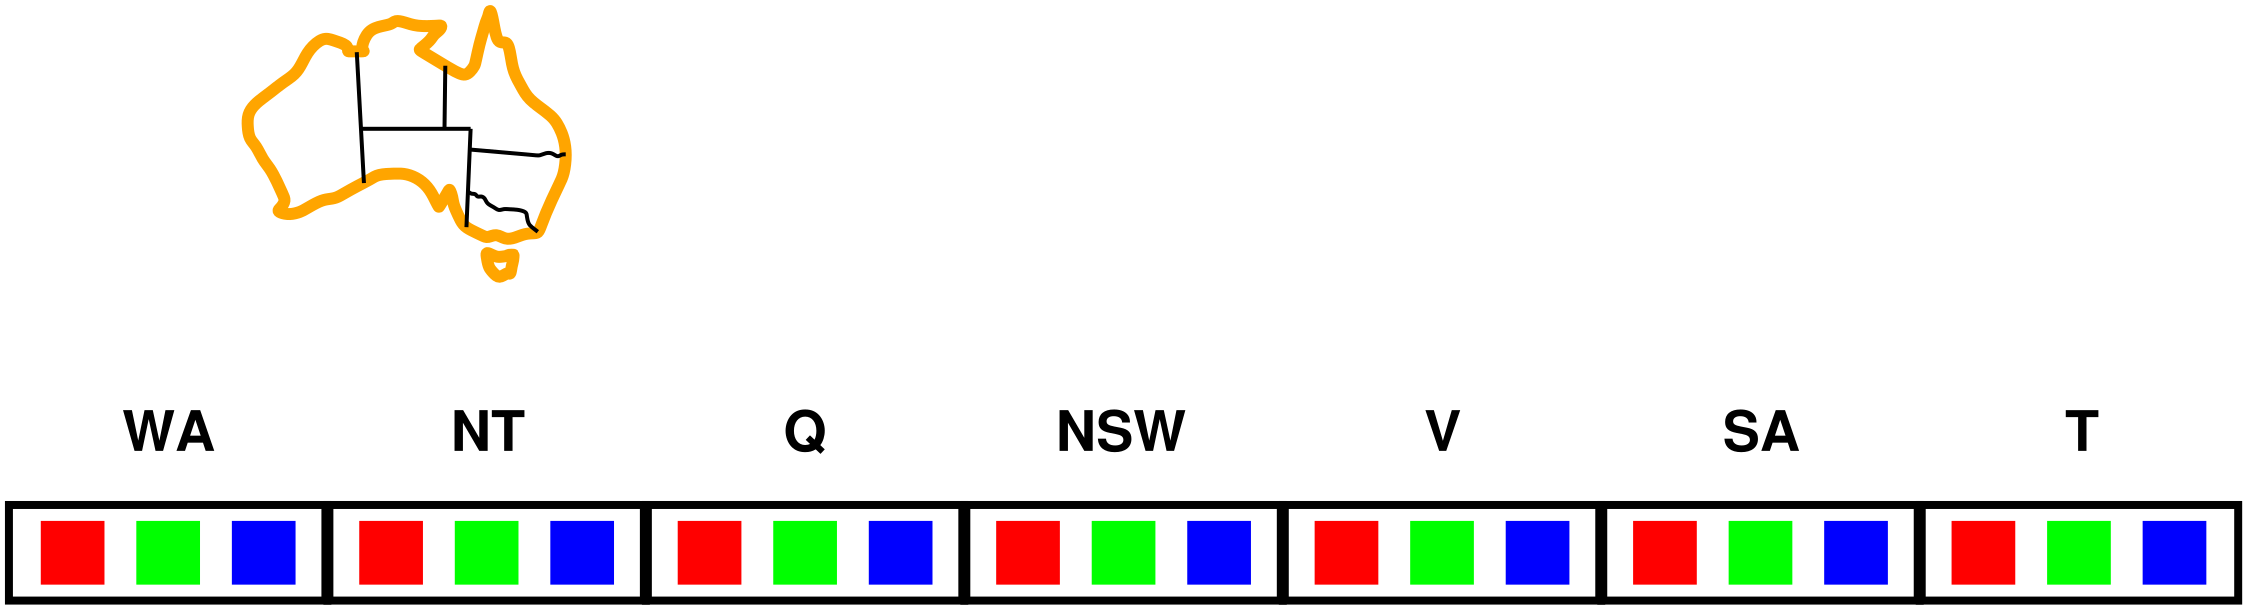

In [ ]:
neighbors = {
    'WA': ['NT', 'SA'], 
    'NT': ['WA', 'SA', 'Q'], 
    'SA': ['WA', 'NT', 'Q', 'NSW', 'V'], 
    'Q': ['NT', 'SA', 'NSW'], 
    'NSW': ['Q', 'SA', 'V'], 
    'V': ['SA', 'NSW'] }

domains = {'WA': ['R', 'G', 'B'], 'NT': ['R', 'G', 'B'], 'Q': ['R', 'G', 'B'], 'NSW': ['R', 'G', 'B'], 'V': ['R', 'G', 'B'],
           'SA': ['R', 'G', 'B'] }

def different_values_constraint(A, a, B, b):
    """A constraint saying two neighboring variables must differ in value."""
    return a != b

In [ ]:
csp = CSP(variables=None, domains=domains, neighbors=neighbors, constraints=different_values_constraint)
print('Variables: {}'.format(csp.variables))
print('Domains: {}'.format(csp.domains))

# Backtracking Search

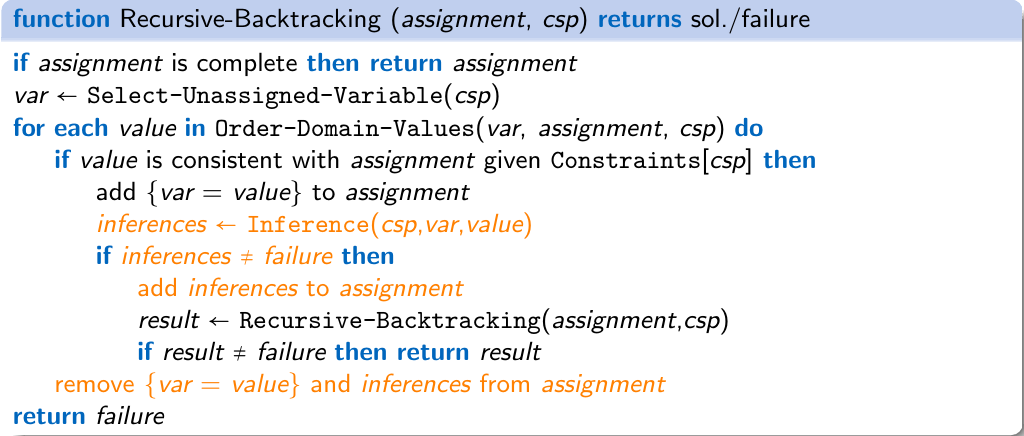

## Step by Step using Forward Checking

Now, we apply a step by step forward checking as an inference algorithm:
1. Assign WA = red. 
    * Arbitary joice: As all domains have the same size, an arbitary domain is chosen.
    * Forward Checking removes the value red from all neighbors of WA so that they are arc-consistent with WA
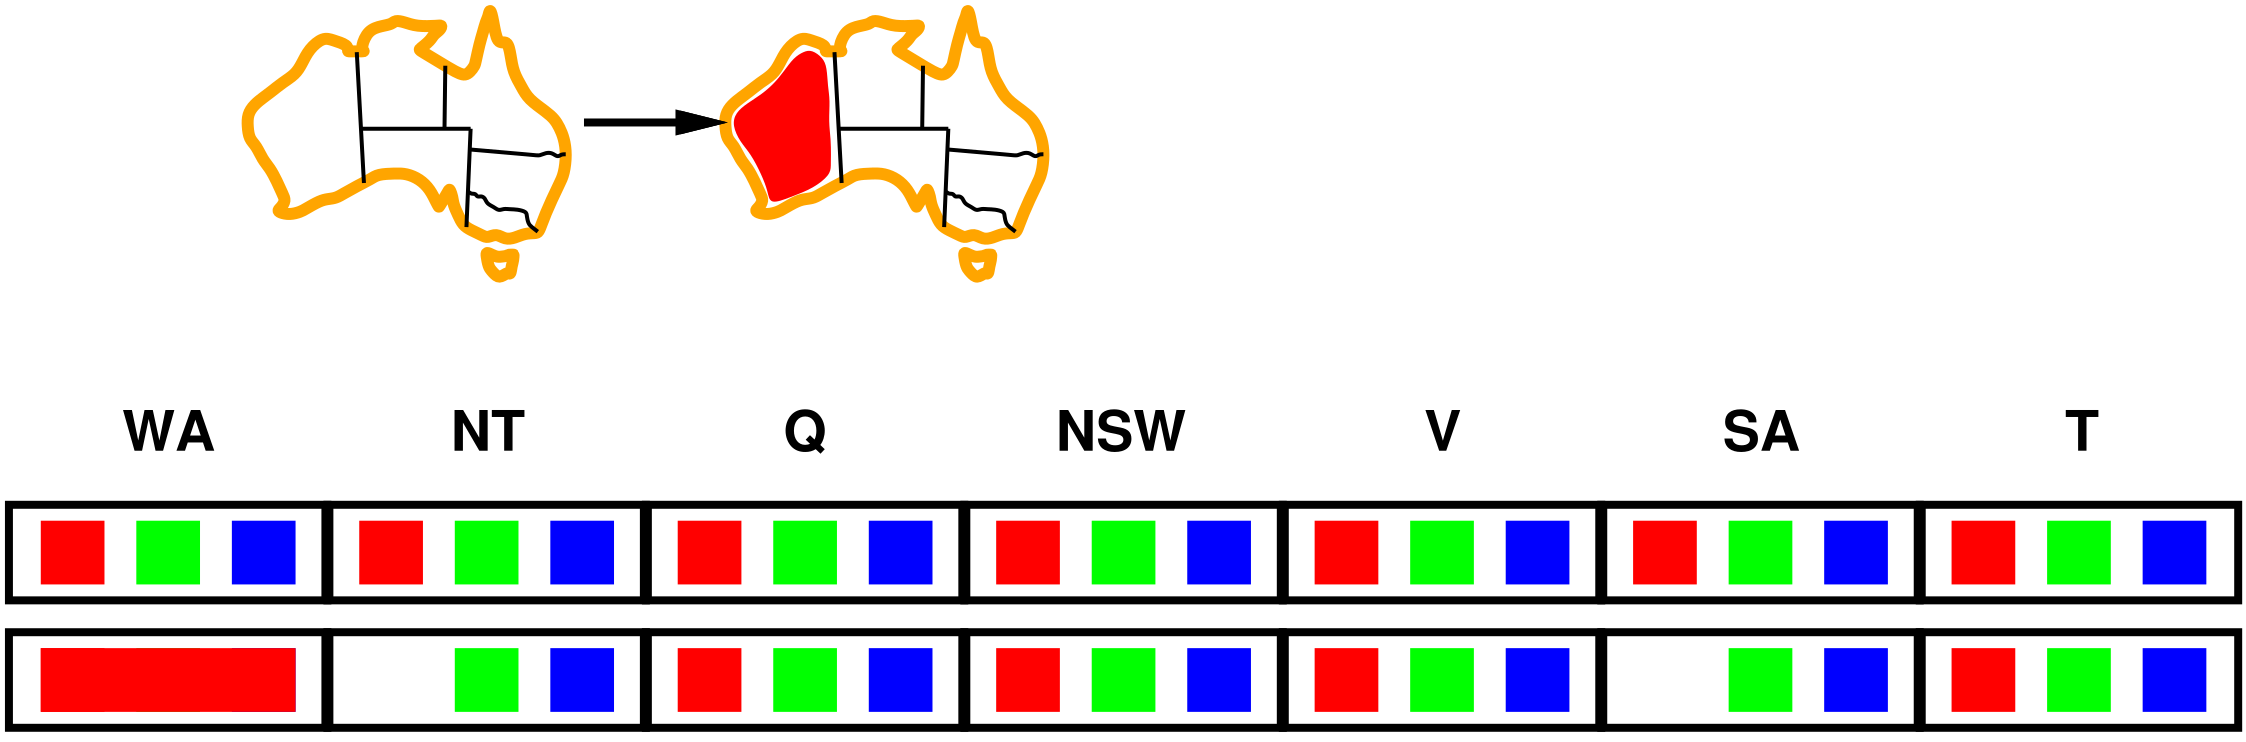
   

In [ ]:
assignments = [('WA', 'R')]
removals = []

csp, removals = forward_checking_step(csp,
                       var = 'WA',
                       value = 'R',
                       assignment = assignments,
                       removals = removals)

2. Assign Q = green.
    * Choice depends on heuristic (**lecture slides 24ff.**)
    * Forward Checking removes the value green from all neighbors of Q so that they are arc-consitent with Q.
    
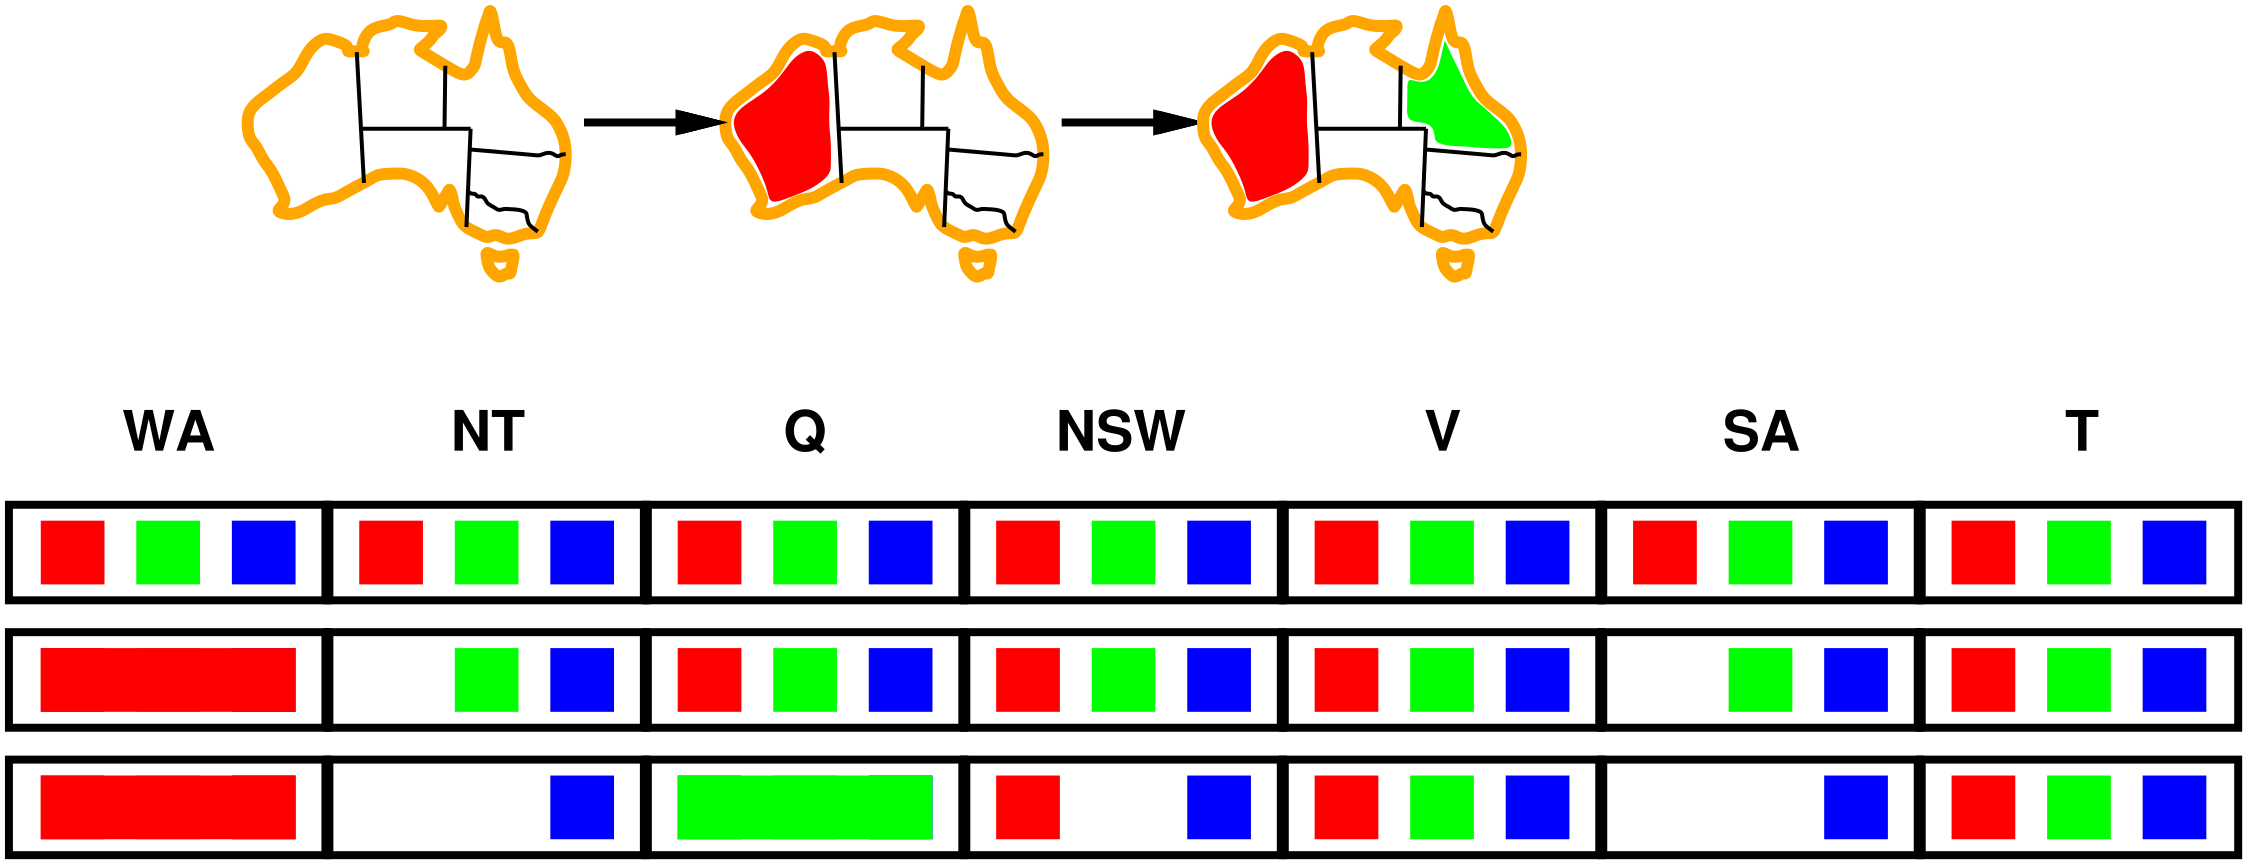

In [ ]:
assignments = [('WA', 'R'), ('Q', 'G')]

csp, removals = forward_checking_step(csp,
                       var = 'Q',
                       value = 'G',
                       assignment = assignments,
                       removals = removals)

In [ ]:
print(removals)

3. Assign V = blue.
    * Choice depends on heuristic
    * Forward Checking removes the value blue from all neighbors of V so that they are arc-consitent with V.
    * This will result in a failure, as the domain of SA is empty
    * The backtracking search will backtack and revoke the lase inconsistent assignment V = blue
    
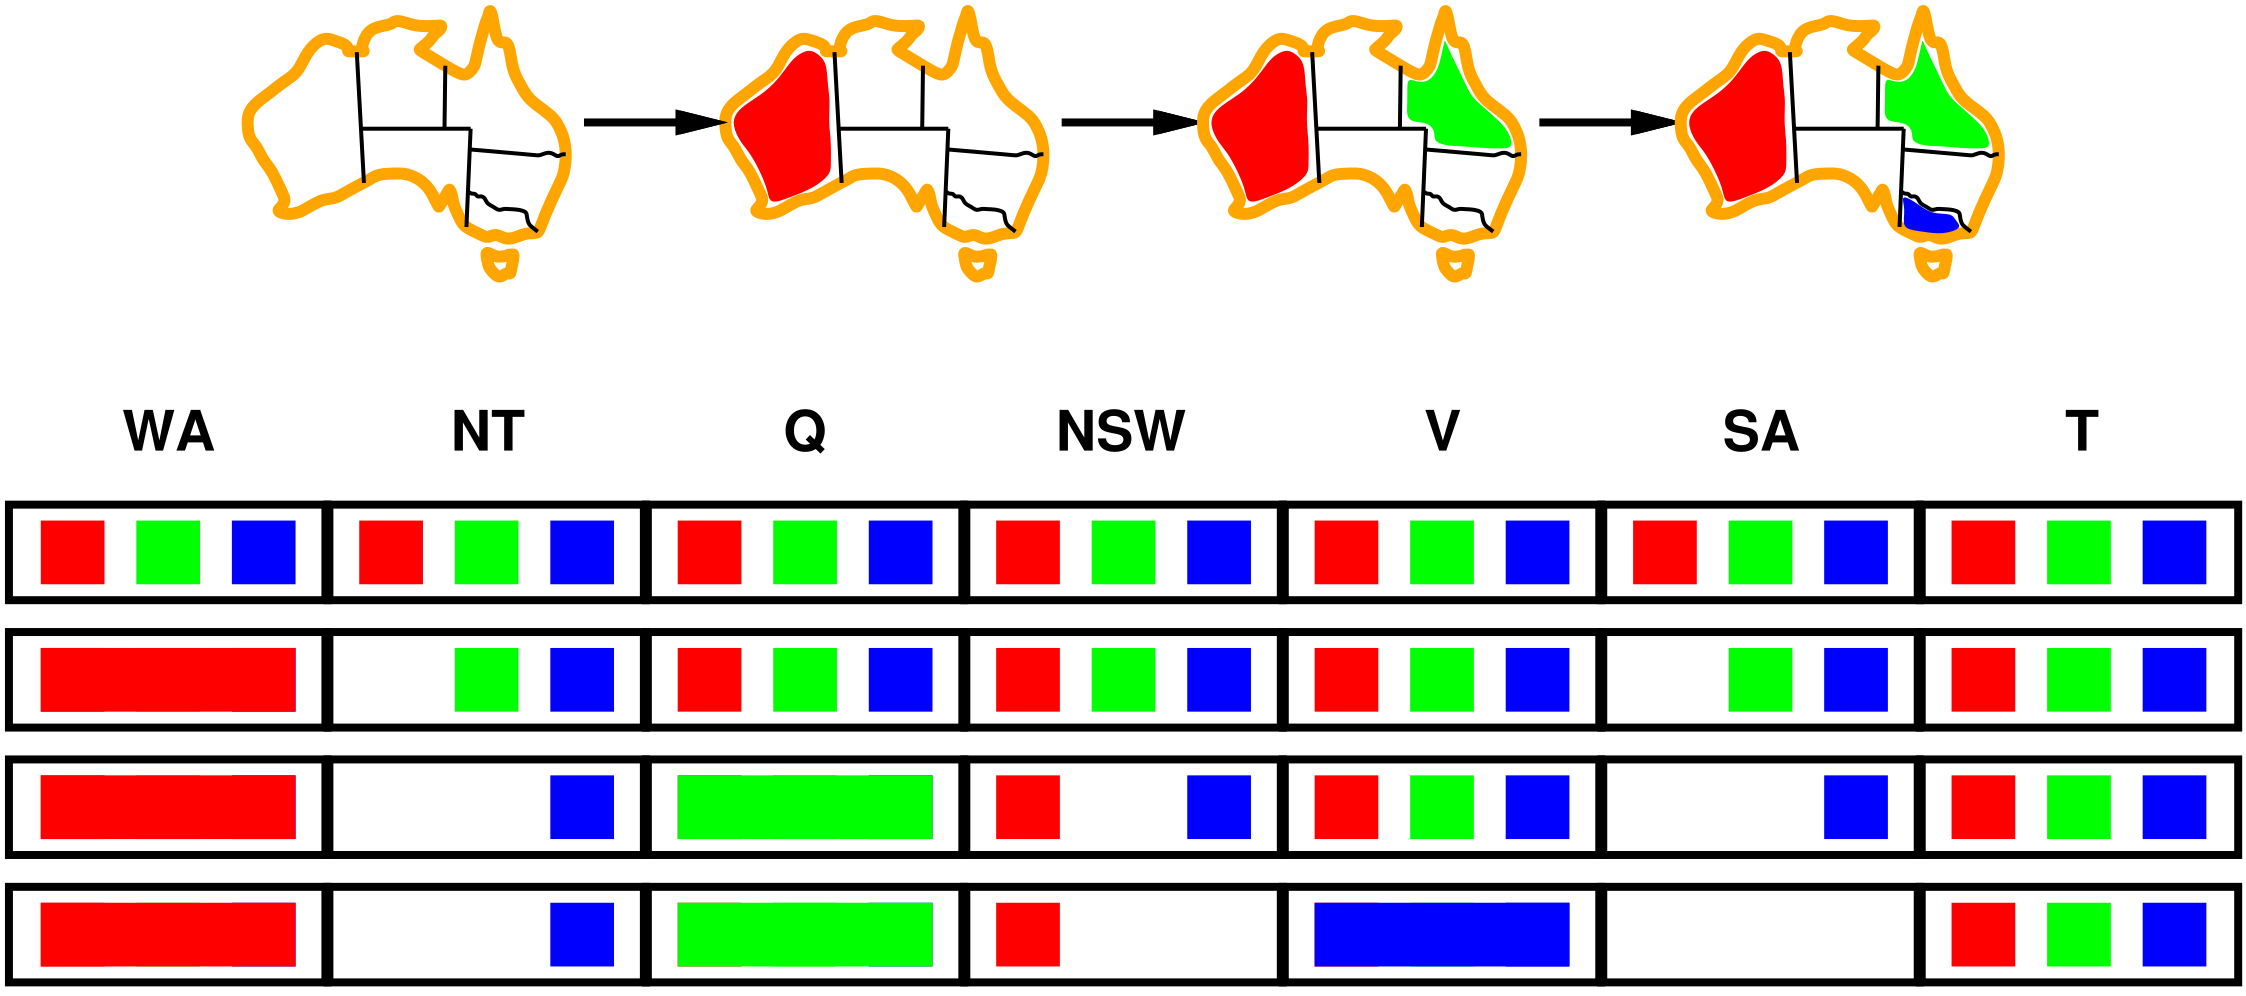

In [ ]:
assignments = [('WA', 'R'), ('Q', 'G'), ('V', 'B')]

csp, removals = forward_checking_step(csp,
                       var = 'V',
                       value = 'B',
                       assignment = assignments,
                       removals = removals)

**Result**

The backtracking search algorithm receives a failure and knows that the CSP cannot be solved with the last assignment V=blue.
Thus, the search algorithm backtracks by removing the inconsistent assignment and restoring the modified domains. If it fails even further it will step back and revoke Q = green. 

## Backtracking Serach using Forward Checking

We now reset our CSP and apply the backtracking search using forward checking. For this purpose we need to redefine the forward checking function as it now only needs to return wether the check was successfull or not.

In [ ]:
def forward_checking(csp, var, value, assignment, removals):
    """Prune neighbor values inconsistent with var=value."""
    csp.support_pruning()
    print('The current assignments:\n{}'.format(assignment))
    for B in csp.neighbors[var]:
        if B not in assignment:
            for b in csp.curr_domains[B][:]:
                if not csp.constraints(var, value, B, b):
                    csp.prune(B, b, removals)
                    print('Remove value '+b+' from domain ' + B)
            if not csp.curr_domains[B]:
                print('Failure since size of Domain({})=0'.format(B))
                return False
    return True

### Backtracking Algorithm Implementation

As mentioned in the lecture the backtracking algorithm needs a heuristic to choose the next assignment. The order in which the domains are assigned is set to be the order in which they have been defined. Here we simply assign the next varible in line starting with WA.

Feel free to change the order in which they are defined in the CSP Problem definition:

In [ ]:
neighbors = {
    'WA': ['NT', 'SA'], 
    'NT': ['WA', 'SA', 'Q'], 
    'SA': ['WA', 'NT', 'Q', 'NSW', 'V'], 
    'Q': ['NT', 'SA', 'NSW'], 
    'NSW': ['Q', 'SA', 'V'], 
    'V': ['SA', 'NSW'] }

domains = {'WA': ['R', 'G', 'B'], 'NT': ['R', 'G', 'B'], 'Q': ['R', 'G', 'B'], 'NSW': ['R', 'G', 'B'], 'V': ['R', 'G', 'B'],
           'SA': ['R', 'G', 'B'] }

def different_values_constraint(A, a, B, b):
    """A constraint saying two neighboring variables must differ in value."""
    return a != b

In [ ]:
csp = CSP(variables=None, domains=domains, neighbors=neighbors, constraints=different_values_constraint)
print('Variables: {}'.format(csp.variables))
print('Domains: {}'.format(csp.domains))

In [ ]:
def first_unassigned_variable(assignment, csp):
    """The default variable order."""
    return first([var for var in csp.variables if var not in assignment])

def unordered_domain_values(var, assignment, csp):
    """The default value order."""
    return csp.choices(var)


def backtracking_search(csp,
                        select_unassigned_variable=first_unassigned_variable,
                        order_domain_values=unordered_domain_values,
                        inference=forward_checking):

    def backtrack(assignment):
        if len(assignment) == len(csp.variables):
            return assignment
        var = select_unassigned_variable(assignment, csp)
        for value in order_domain_values(var, assignment, csp):
            if 0 == csp.nconflicts(var, value, assignment):
                print('Try assignment of ' + value + ' to ' + var)
                csp.assign(var, value, assignment)
                removals = csp.suppose(var, value)
                if inference(csp, var, value, assignment, removals):
                    result = backtrack(assignment)
                    if result is not None:
                        return result
                csp.restore(removals)
        csp.unassign(var, assignment)
        return None

    result = backtrack({})
    assert result is None or csp.goal_test(result)
    print('Result:')
    return result

In [ ]:
backtracking_search(csp)

# What's next

Congratulation on completing this notebook! Now you have a better understanding of forward checking. 

The next notebook is about ***Lecture 5: Constraint Satisfaction Problems - Arc-consistency algorithm***
